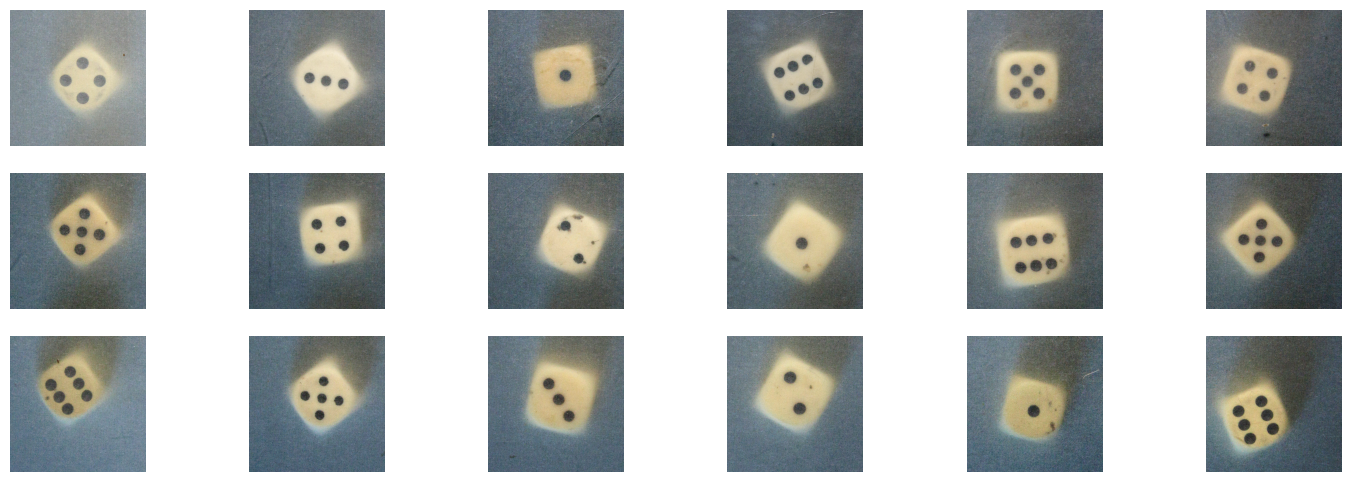

In [233]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Specify the path to the image file
# image_path = 'data/IMG_0179-3000px.jpg'
# image_path = 'data/IMG_0180-3000px.jpg'
# image_path = 'data/IMG_0181-3000px.jpg'
image_path = 'data/IMG_0185-3000px.jpg'
# Load the image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# normalize the image
# image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)

def extract_dices_from_example_image(img, rows=3, cols = 6):

    # Calculate the height and width of each dice
    height = image.shape[0] // rows
    width = image.shape[1] // cols

    # Initialize a list to store the extracted dice images
    dice_images = []

    # Iterate over each dice in the matrix
    for r in range(rows):
        for c in range(cols):
            # Calculate the coordinates of the current dice
            x = c * width
            y = r * height

            # Extract the current dice from the image
            dice = image[y:y+height, x:x+width]

            # remove 15 pixels from each side
            dice = dice[15:-15, 15:-15]

            dice = cv2.normalize(dice, None, 0, 255, cv2.NORM_MINMAX)



            # Append the dice image to the list
            dice_images.append(dice)

    return dice_images


# image is 6x3 grid of dices with one face up each

rows = 3
cols = 6
dice_images = extract_dices_from_example_image(image, rows, cols)

# Display the extracted dice images in a grid
plt.figure(figsize=(rows * cols, cols))
for i, dice in enumerate(dice_images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(dice)
    plt.axis('off')

In [261]:
def get_edges(img, blur=5, dilate_erode_kerner_size=2, dilate_iterations=3, erode_iterations=1):
    source = img.copy()
    source = cv2.GaussianBlur(source, (blur, blur), 0)
    source = cv2.cvtColor(source, cv2.COLOR_RGB2GRAY)
    source = cv2.normalize(source, None, 0, 255, cv2.NORM_MINMAX)
    # extract edges
    edges = cv2.Canny(source, 90, 200)

    # dilate edges
    kernel = np.ones((dilate_erode_kerner_size, dilate_erode_kerner_size), np.uint8)
    edges = cv2.dilate(edges, kernel, iterations=dilate_iterations)

    # # erosion
    edges = cv2.erode(edges, kernel, iterations=erode_iterations)

    return edges


def get_contours (edges, min_area=1000, max_area=2000, verbose=False):

    # find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # approximate contours by their convex hull
    contours = [cv2.convexHull(c) for c in contours]

   # remove small and large  contours
    contours = [c for c in contours if min_area < cv2.contourArea(c) < max_area]

 


    # check if contour is approximately a circle by 
    # comparing the length of the contour with the circumference of a circle with the same area
    contours = [c for c in contours if cv2.arcLength(c, True) < 1.5 * np.pi * cv2.contourArea(c) ** 0.5]

    if verbose:
        # print minimal and maximal contour area
        if len(contours) > 0:
            print(f"min: {min([cv2.contourArea(c) for c in contours])}, max: {max([cv2.contourArea(c) for c in contours])}")
        else:
            print("no contours found")


    return contours

def get_dice_value(img, blur=5, min_area=1000, max_area=20000, verbose=False):
    edges = get_edges(img, blur)
    contours = get_contours(edges, min_area, max_area, verbose)

    if verbose:
        edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)
        for c in contours:
            cv2.drawContours(edges, [c], -1, (255, 0, 0), 2)
        plt.imshow(edges)
    return len(contours)



In [275]:
2000 / len(dice_images[0])**2

0.009053870529651425

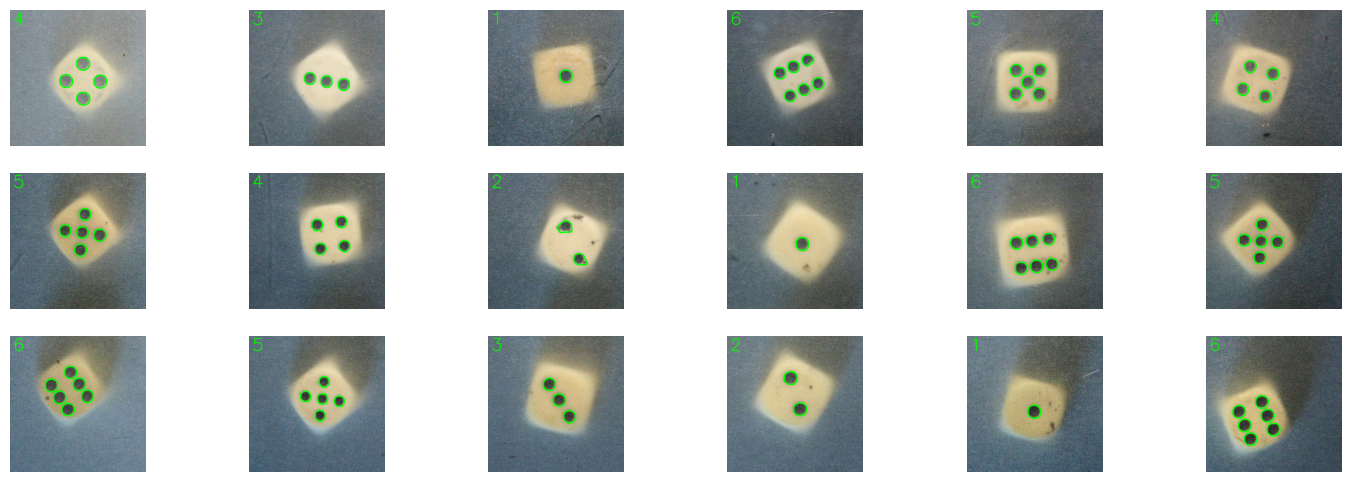

In [284]:
# apply to all images
img_size = len(dice_images[0])**2

min_area = (0.36 / 100) *  img_size # in percent of the image size
max_area = (0.9 / 100) * img_size # in percent of the image size

plt.figure(figsize=(rows * cols, cols))
for i, dice in enumerate(dice_images):

    edges = get_edges(dice)
    contours = get_contours(edges, min_area=min_area, max_area=max_area, verbose=False)


    # count eyes
    eyes = len(contours)

    plt.subplot(rows, cols, i + 1)

    # display contours on source image
    in_dice = dice.copy()
    cv2.drawContours(in_dice, contours, -1, (0, 255, 0), 3)
    # add number of eyes
    cv2.putText(in_dice, str(eyes), (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 2, cv2.LINE_AA)
    plt.imshow(in_dice)


    # display edges
    # convert edges to color
    # edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)
    # add number of eyes
    # cv2.putText(edges, str(eyes), (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 255), 2, cv2.LINE_AA)
    # cv2.drawContours(edges, contours, -1, (0, 255, 0), 3)
    
    # plt.imshow(edges, cmap='gray')
    plt.axis('off')





min: 1154.5, max: 1258.5


6

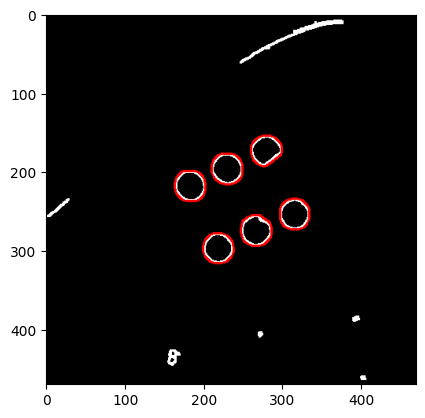

In [289]:
get_dice_value(dice_images[3], min_area=800, max_area=2000, verbose=True) 

plt.

In [211]:
dice_eyes = [get_dice_value(dice, min_area=600, max_area=2000,) for dice in dice_images]
print(dice_eyes)

[4, 3, 1, 6, 5, 4, 5, 4, 2, 1, 6, 5, 6, 5, 3, 2, 1, 6]


In [290]:
# save dice_images into separate jpgs
for i, dice in enumerate(dice_images):
    cv2.imwrite(f"data/dice_{i}_eyes_{dice_eyes[i]}.jpg", cv2.cvtColor(dice, cv2.COLOR_RGB2BGR))